In [11]:
import xarray as xr
xr.set_options(display_style='html')  # make xarray summary look better
import numpy as np 


# Some custom plotting stuff because I can't stand defualt matplotlib 
import matplotlib.pyplot as plt
import sciplotlib.style as splstyle
import sciplotlib.polish as splpolish

# Xarray is just a wrapper around numpy arrays / dataframes

### Let's generate some fake neural data to illustrate this

In [2]:
num_cell = 1000 
experiment_duration_s = 600
sampling_rate = 20   # ie. 50 ms time bins
spike_rate = np.random.normal(size=(num_cell, experiment_duration_s * sampling_rate))

# normally we also have other information associated with out neural data 
mouse_name = 'Mickey'
recording_date = '2020-02-02'
exeriment_number = 3

In [3]:
np.shape(spike_rate)

(1000, 12000)

### We want it to be clear to the coder / collaborator who will look at your data want the dimensions of your array mean

Xarray uses `dataArray` and `dataset` objects to wrap around your data arrays. 

(`dataset` allows for storing multiple variables, as we will see, and in practice I find myself using `dataset` 95% of the time, so we will focus on this today)

In [4]:
spike_ds = xr.Dataset(
    {'SpikeRate': (['Cell', 'Time'], spike_rate)},
    coords={'Cell': ('Cell', np.arange(np.shape(spike_rate)[0])),
           'Time': ('Time', np.arange(np.shape(spike_rate)[1]))
           }
)

spike_ds.attrs['Subject'] = mouse_name
spike_ds.attrs['Date'] = recording_date
spike_ds.attrs['experiment_number'] = exeriment_number

In [20]:
spike_ds

<xarray.Dataset>
Dimensions:    (Cell: 1000, Time: 12000)
Coordinates:
  * Cell       (Cell) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * Time       (Time) int64 0 1 2 3 4 5 ... 11994 11995 11996 11997 11998 11999
Data variables:
    SpikeRate  (Cell, Time) float64 0.9842 1.549 -1.274 ... -1.658 0.3126
Attributes:
    Subject:            Mickey
    Date:               2020-02-02
    experiment_number:  3

### A single dimension can have multiple coordinates

Dimension and coordinates allows you to select your data easily. 

In time series data, we often think both in terms of time bin number and the actual acquisition time of the neural data (especially in two-photon data, where the sampling rate is quite low), and this can be expressed as having a 'Time' dimension with both a time bin and acquisition time coordinate.

In [24]:
np.shape(spike_rate)

(1000, 12000)

In [23]:
np.shape(acqTime)

(12000,)

In [5]:
experiment_start_time = -9.7   # eg. you need to align your neural acquisition time to some other acquisition device
experiment_end_time =  experiment_start_time + experiment_duration_s
acqTime = np.linspace(experiment_start_time, experiment_end_time, experiment_duration_s * sampling_rate)


spike_ds = xr.Dataset(
    {'SpikeRate': (['Cell', 'Time'], spike_rate)},
    coords={'Cell': ('Cell', np.arange(np.shape(spike_rate)[0])),
           'Bin': ('Time', np.arange(np.shape(spike_rate)[1])), 
            'AcqTime': ('Time', acqTime)
           }
)

# Sidenote: note that a coordinate can have the same name as the dimension,
# which can cause confusion in some tutorials you read online


In [26]:
spike_ds

<xarray.Dataset>
Dimensions:    (Cell: 1000, Time: 12000)
Coordinates:
  * Cell       (Cell) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
    Bin        (Time) int64 0 1 2 3 4 5 ... 11994 11995 11996 11997 11998 11999
    AcqTime    (Time) float64 -9.7 -9.65 -9.6 -9.55 ... 590.1 590.2 590.2 590.3
Dimensions without coordinates: Time
Data variables:
    SpikeRate  (Cell, Time) float64 0.9842 1.549 -1.274 ... -1.658 0.3126

Another example is if you have some coordinate that describes your cell; eg. literal dorsal-ventral coordinates

In [28]:
probe_dorsal_pos = 3
probe_ventral_pos = 2
cell_dorsal_pos = np.random.normal(size=num_cell, loc=probe_dorsal_pos, scale=0.1)
cell_ventral_pos = np.random.normal(size=num_cell, loc=probe_ventral_pos, scale=0.1)

spike_ds = xr.Dataset(
    {'SpikeRate': (['Cell', 'Time'], spike_rate)},
    coords={'Cell': ('Cell', np.arange(np.shape(spike_rate)[0])),
           'Bin': ('Time', np.arange(np.shape(spike_rate)[1])), 
            'Time': ('Time', acqTime),
            'DorsalPos': ('Cell', cell_dorsal_pos),
            'VentralPos': ('Cell', cell_ventral_pos)
           }
)


In [29]:
spike_ds

<xarray.Dataset>
Dimensions:     (Cell: 1000, Time: 12000)
Coordinates:
  * Cell        (Cell) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
    Bin         (Time) int64 0 1 2 3 4 5 ... 11994 11995 11996 11997 11998 11999
  * Time        (Time) float64 -9.7 -9.65 -9.6 -9.55 ... 590.1 590.2 590.2 590.3
    DorsalPos   (Cell) float64 2.903 2.98 2.991 3.085 ... 3.021 3.009 2.981
    VentralPos  (Cell) float64 1.952 1.862 1.954 2.056 ... 2.195 2.096 2.058
Data variables:
    SpikeRate   (Cell, Time) float64 0.1903 -0.7258 -1.236 ... 2.812 0.3198

Technical detail: 
    
   - coordinates in bold have the same name as the dimension, and are *index coordinates*, we will see in the next section that this means that they are the coordinates to be used by default when performing indexing 

## Xarray makes data selection and computation more readable

### Indexing: we want to plot a specific cell

In [30]:
cell_id = 3 
cell_ds = spike_ds.sel(Cell=cell_id)

In [31]:
cell_ds

<xarray.Dataset>
Dimensions:     (Time: 12000)
Coordinates:
    Cell        int64 3
    Bin         (Time) int64 0 1 2 3 4 5 ... 11994 11995 11996 11997 11998 11999
  * Time        (Time) float64 -9.7 -9.65 -9.6 -9.55 ... 590.1 590.2 590.2 590.3
    DorsalPos   float64 3.085
    VentralPos  float64 2.056
Data variables:
    SpikeRate   (Time) float64 0.09324 0.7627 0.5299 ... 2.902 -0.5508 0.3164

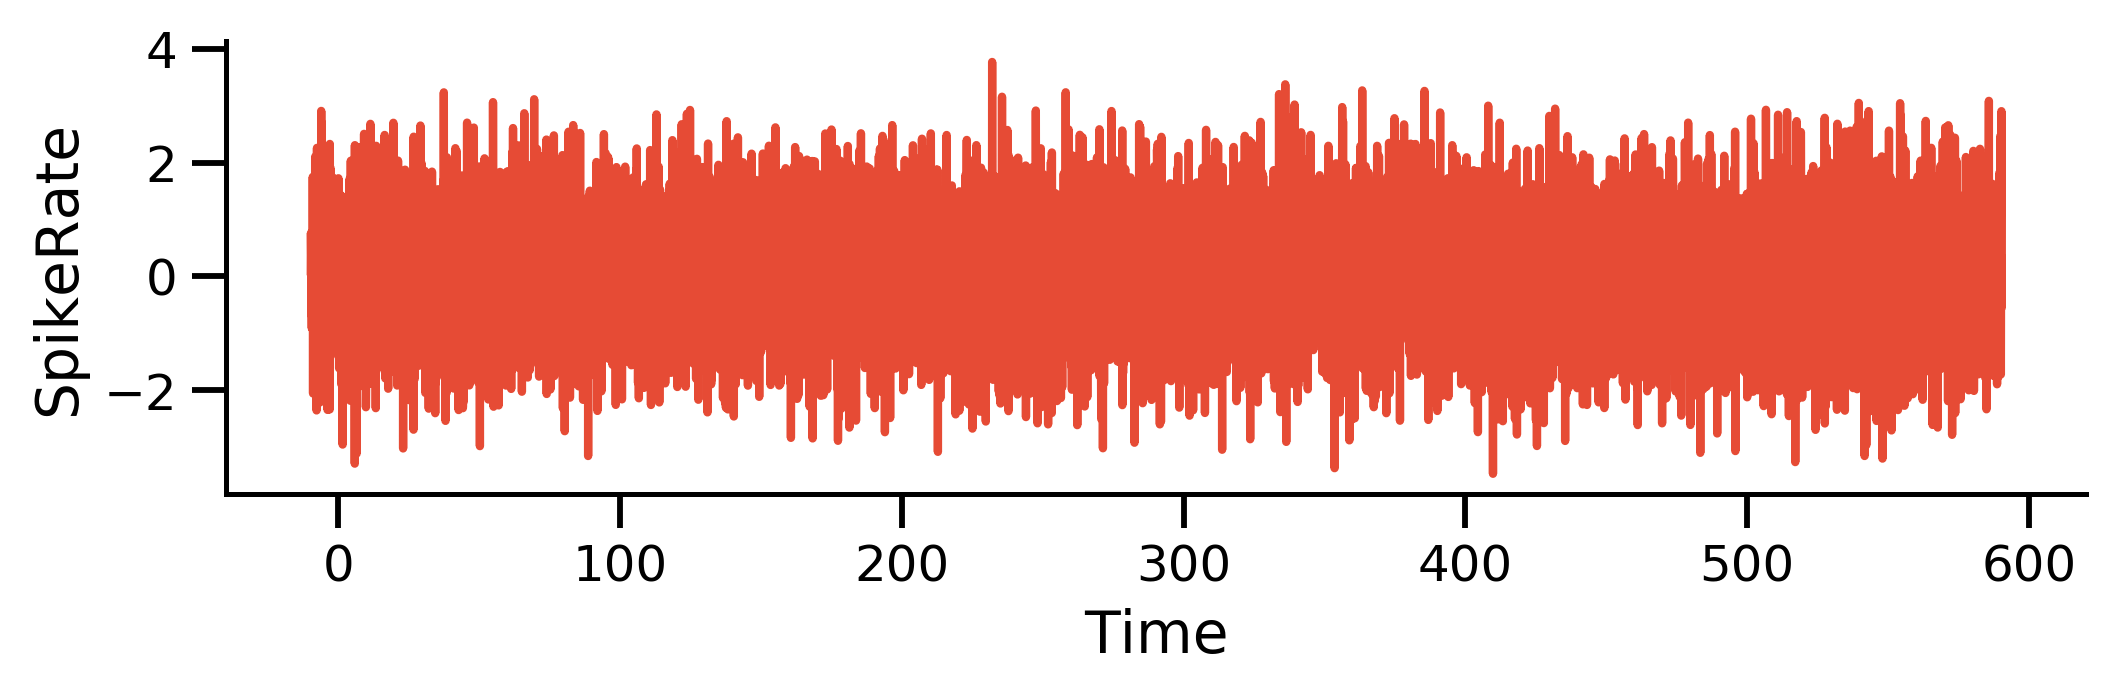

In [34]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 2)
    x_axis_variable_name = 'Time'
    y_axis_variable_name = 'SpikeRate'
    ax.plot(cell_ds[x_axis_variable_name], cell_ds[y_axis_variable_name])
    ax.set_xlabel(x_axis_variable_name)
    ax.set_ylabel(y_axis_variable_name)

### Slicing: we want to plot a specific time range

Method 1, we can slice using the acquisition time coordinate

In [35]:
time_start = 30
time_end = 101
cell_ds_time_sliced = cell_ds.sel(Time=slice(time_start, time_end))

In [36]:
cell_ds_time_sliced

<xarray.Dataset>
Dimensions:     (Time: 1420)
Coordinates:
    Cell        int64 3
    Bin         (Time) int64 794 795 796 797 798 ... 2209 2210 2211 2212 2213
  * Time        (Time) float64 30.0 30.05 30.1 30.15 ... 100.8 100.9 100.9 101.0
    DorsalPos   float64 3.085
    VentralPos  float64 2.056
Data variables:
    SpikeRate   (Time) float64 0.3291 0.6624 -0.2438 ... 0.3541 -0.57 0.6656

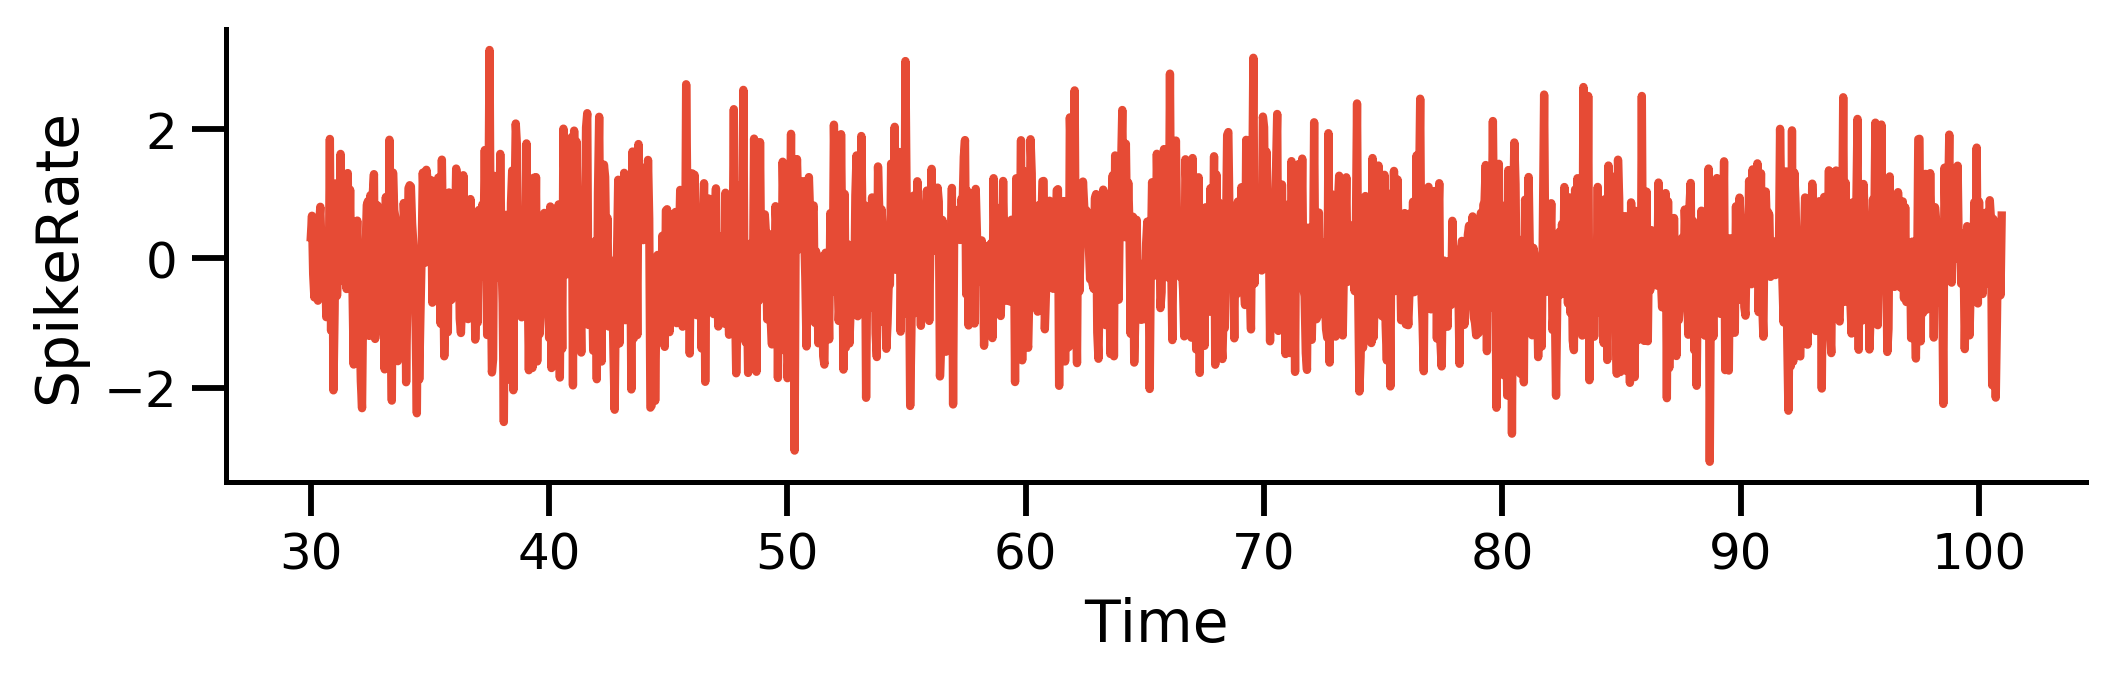

In [37]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 2)
    x_axis_variable_name = 'Time'
    y_axis_variable_name = 'SpikeRate'
    ax.plot(cell_ds_time_sliced[x_axis_variable_name], cell_ds_time_sliced[y_axis_variable_name])
    ax.set_xlabel(x_axis_variable_name)
    ax.set_ylabel(y_axis_variable_name)

Method 2: we can slice based on the built in indices (ie. integer values starting at 0)

In [42]:
time_start_idx = 30
time_end_idx = 100
cell_ds_time_sliced = cell_ds.isel(Time=slice(time_start_idx, time_end_idx))

In [43]:
cell_ds_time_sliced

<xarray.Dataset>
Dimensions:     (Time: 70)
Coordinates:
    Cell        int64 3
    Bin         (Time) int64 30 31 32 33 34 35 36 37 ... 92 93 94 95 96 97 98 99
  * Time        (Time) float64 -8.2 -8.15 -8.1 -8.05 ... -4.9 -4.85 -4.8 -4.75
    DorsalPos   float64 3.085
    VentralPos  float64 2.056
Data variables:
    SpikeRate   (Time) float64 -0.8605 2.102 0.1598 ... 0.3358 0.8521 -0.3303

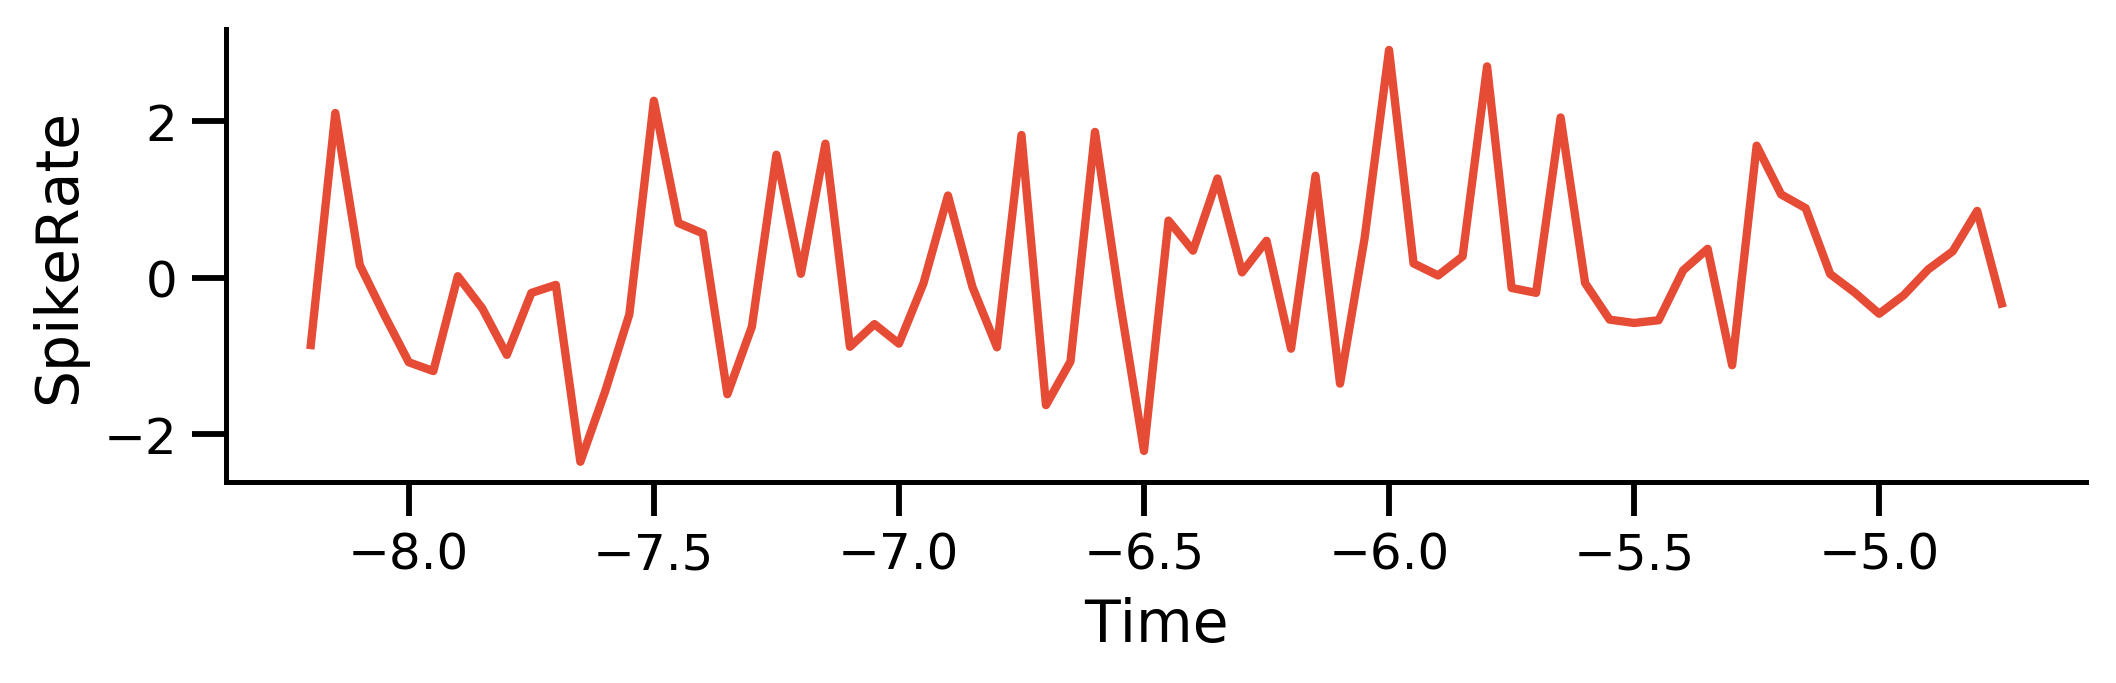

In [44]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 2)
    x_axis_variable_name = 'Time'
    y_axis_variable_name = 'SpikeRate'
    ax.plot(cell_ds_time_sliced[x_axis_variable_name], cell_ds_time_sliced[y_axis_variable_name])
    ax.set_xlabel(x_axis_variable_name)
    ax.set_ylabel(y_axis_variable_name)

Method 3: We can use methods similar to `np.where` to susbset our data

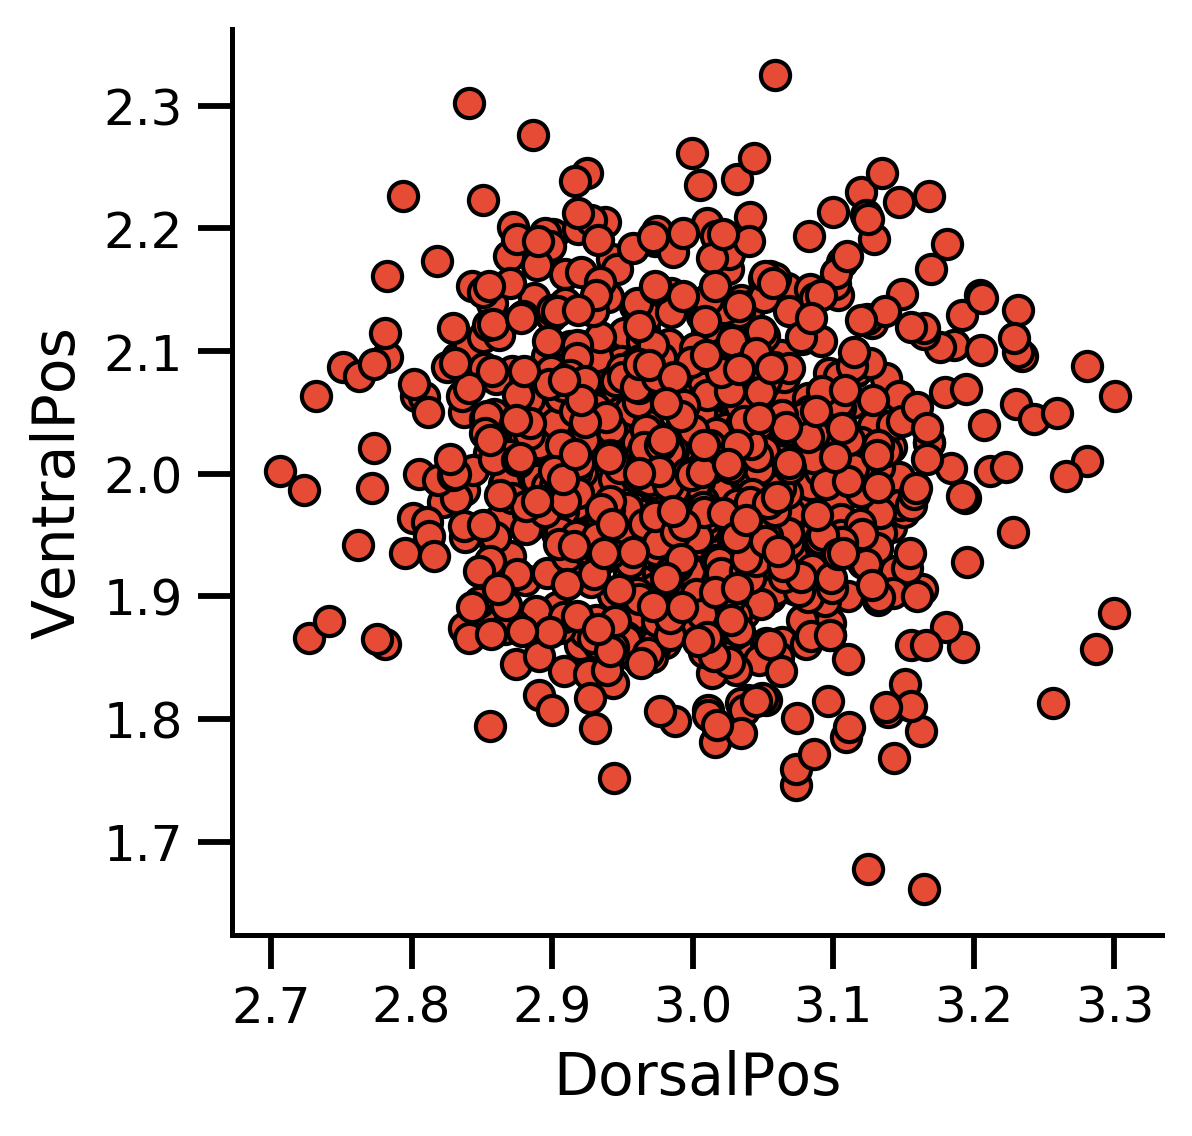

In [65]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 4)
    x_axis_variable = 'DorsalPos'
    y_axis_variable = 'VentralPos'
    ax.scatter(spike_ds[x_axis_variable], spike_ds[y_axis_variable])
    ax.set_xlabel(x_axis_variable)
    ax.set_ylabel(y_axis_variable)

In [67]:
dorsal_pos_range = [3.2, 3.3]
ventral_pos_range = [1.8, 1.9]

subset_spike_ds = spike_ds.where(
    (spike_ds['DorsalPos'] >= dorsal_pos_range[0]) &
    (spike_ds['DorsalPos'] <= dorsal_pos_range[1]) & 
    (spike_ds['VentralPos'] >= ventral_pos_range[0]) &
    (spike_ds['VentralPos'] <= ventral_pos_range[1]), 
    drop=True
)

In [68]:
subset_spike_ds

<xarray.Dataset>
Dimensions:     (Cell: 3, Time: 12000)
Coordinates:
  * Cell        (Cell) int64 221 360 564
    Bin         (Time) int64 0 1 2 3 4 5 ... 11994 11995 11996 11997 11998 11999
  * Time        (Time) float64 -9.7 -9.65 -9.6 -9.55 ... 590.1 590.2 590.2 590.3
    DorsalPos   (Cell) float64 3.3 3.256 3.287
    VentralPos  (Cell) float64 1.886 1.813 1.857
Data variables:
    SpikeRate   (Cell, Time) float64 0.6562 -0.5904 1.952 ... -0.1506 -1.453